## Data Augmentation
Ce script vise à augmenter le nombre de données pour le problème de régression.
Pour chaque photo du dataset, on transforme la photo et on lui associe le même label que la photo initiale.
Les transformations utilisées sont les suivantes :
- Augmentation / Diminution du contraste
- Ajout d'un bruit gaussien
- Augmentation / Diminution de la luminosité
- Floutage de la photo

In [124]:
# Importation des librairies utiles
import os
import cv2
import time
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

In [125]:
# Chemin vers les données
PATH_IMG = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/img/"
PATH_LABEL = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/labels/regression"

In [126]:
# Lecture des données
def load_data(path_img, path_labels, img_size=64):
    x_data = list()
    y_data = list()
    print("Lecture des données...")
    for file in os.listdir(path_labels):
        if not os.path.isfile(os.path.join(path_labels, file)):
            continue
        name, ext = file.split(".")
        img_name = str(name) + ".jpg"
        if img_name in os.listdir(path_img):
            # Lecture de l'image
            img_path = os.path.join(path_img, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size)).astype(np.float32)
            # Lecture du label
            with open(os.path.join(path_labels, file), 'r') as file_label:
                label = file_label.read()
            # Ajout de la donnée
            x_data.append(img)
            y_data.append(int(label))
            
    return x_data, y_data

In [127]:
t1 = time.time()
x_data, y_data = load_data(PATH_IMG, PATH_LABEL, img_size=256)
t2 = time.time()
print("Durée pour lire les données : {}s".format(round(t2-t1, 3)))

Lecture des données...
Durée pour lire les données : 81.158s


In [128]:
def display_random(data_set):
    i = randint(0, len(data_set)-1)
    img = data_set[i]
    plt.figure(figsize=(8, 8))
    plt.imshow(img.astype(np.uint8), interpolation='nearest')
    plt.axis('off')
    plt.show()
    return img

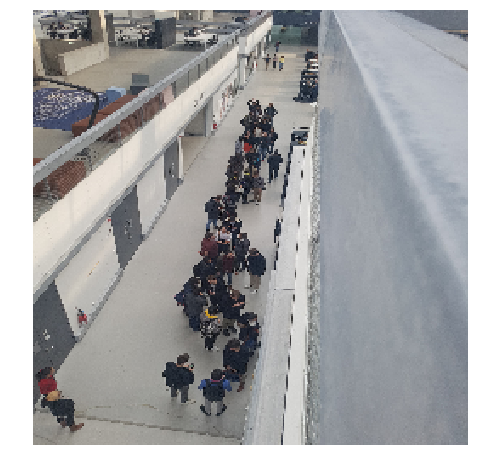

In [129]:
img = display_random(x_data)

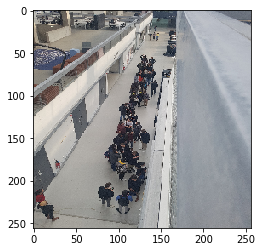

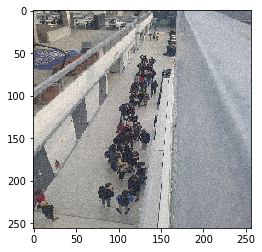

In [134]:
def add_noise(img, std=1, display=False):
    """
    Add Gaussian noise to the img
    """
    sigma = np.sqrt(std)
    gaussian = np.random.normal(0, sigma, (256, 256))

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)
    
    if display:
        plt.imshow(img.astype(np.uint8), interpolation='nearest')
        plt.show()
        plt.imshow(noisy_image, interpolation='nearest')
        plt.show()
    
    return noisy_image

noisy_img = add_noise(img, std=100, display=True)

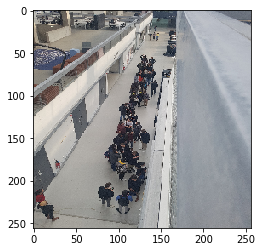

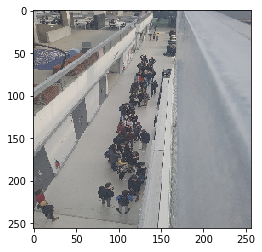

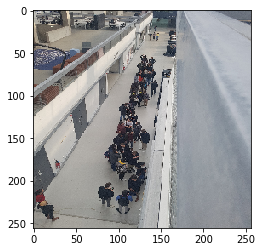

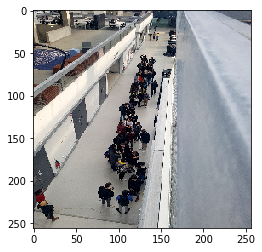

In [136]:
def change_contrast(img, k=2, display=False):
    """
    Change contrast on one image
    """
    img = img.astype(np.uint8)
    img_pil = Image.fromarray(img)
    contrast = ImageEnhance.Contrast(img_pil)
    new_img = contrast.enhance(k)
    if display:
        plt.imshow(img.astype(np.uint8), interpolation='nearest')
        plt.show()
        plt.imshow(new_img, interpolation='nearest')
        plt.show()
    new_img = np.array(new_img)
    return new_img

contrasted_img = change_contrast(img, k=1/1.3, display=True)
contrasted_img = change_contrast(img, k=1.3, display=True)

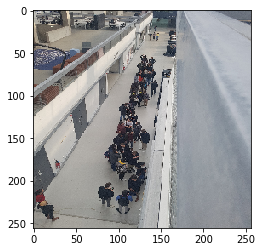

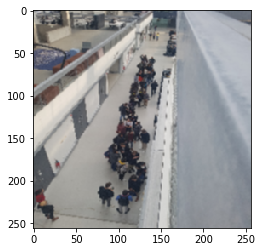

In [137]:
def blur_img(img, k=5, display=False):
    """
    Blur one image
    """
    blur = cv2.GaussianBlur(img, (k,k), 0)
    blur = blur.astype(np.uint8)
    if display:
        plt.imshow(img.astype(np.uint8), interpolation='nearest')
        plt.show()
        plt.imshow(blur, interpolation='nearest')
        plt.show()
        
    return blur

img_blur = blur_img(img, k=3, display=True)

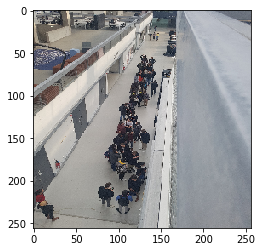

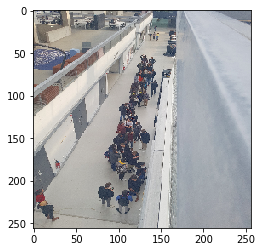

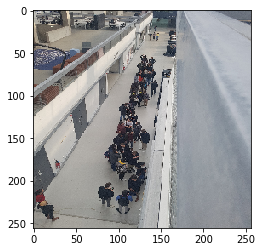

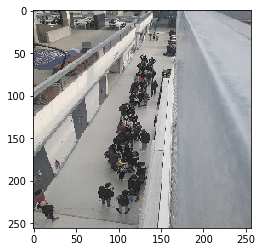

In [139]:
def change_brightness(img, k=0, display=False):
    """
    Change brightness on one image
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] += k
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    cv2.normalize(new_img, new_img, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    new_img = new_img.astype(np.uint8)
    if display:
        plt.imshow(img.astype(np.uint8), interpolation='nearest')
        plt.show()
        plt.imshow(new_img, interpolation='nearest')
        plt.show()
    
    return new_img

bright_img = change_brightness(img, k=30, display=True)
bright_img = change_brightness(img, k=-30, display=True)

In [140]:
def process_one_img(img, std_noise=1, k_contrast=1, k_blur=0, k_brightness=0, 
                    path_img="", path_label="", name_img="", label_img=""):
    """
    Apply transformation to one image
    """
    save=False
    if path_img != "" and path_label != "" and name_img != "" and label_img != "":
        save = True
        
    if not os.path.exists(path_img):
        raise NameError("path {} does not exists".format(path_img))
    if not os.path.exists(path_label):
        raise NameError("path {} does not exists".format(path_label))
    
    new_imgs = list()
    if std_noise != 1:
        img_noise = add_noise(img, std=std_noise)
        new_imgs.append(img_noise)
        if save:
            img_noise = cv2.cvtColor(img_noise, cv2.COLOR_RGB2BGR)
            new_path_img = os.path.join(path_img, "noise", name_img + "_noise.jpg")
            cv2.imwrite(new_path_img, img_noise)
            new_path_label = os.path.join(path_label, name_img + "_noise.txt")
            with open(new_path_label, 'w') as file:
                file.write(str(label_img))
    if k_contrast != 1:
        img_contrast = change_contrast(img, k=k_contrast)
        img_contrast_inv = change_contrast(img, k=1/k_contrast)
        new_imgs.extend([img_contrast, img_contrast_inv])
        if save:
            img_contrast = cv2.cvtColor(img_contrast, cv2.COLOR_RGB2BGR)
            img_contrast_inv = cv2.cvtColor(img_contrast_inv, cv2.COLOR_RGB2BGR)
            new_path_img = os.path.join(path_img, "contrast", name_img + "_contrast.jpg")
            new_path_img1 = os.path.join(path_img, "contrast", name_img + "_uncontrast.jpg")
            cv2.imwrite(new_path_img, img_contrast)
            cv2.imwrite(new_path_img1, img_contrast_inv)
            
            new_path_label = os.path.join(path_label, name_img + "_contrast.txt")
            new_path_label1 = os.path.join(path_label, name_img + "_uncontrast.txt")
            with open(new_path_label, 'w') as file:
                file.write(str(label_img))
            with open(new_path_label1, 'w') as file:
                file.write(str(label_img))
    if k_blur != 0:
        img_blur = blur_img(img, k=k_blur)
        new_imgs.append(img_blur)
        if save:
            img_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2BGR)
            new_path_img = os.path.join(path_img, "blur", name_img + "_blur.jpg")
            cv2.imwrite(new_path_img, img_blur)
            new_path_label = os.path.join(path_label, name_img + "_blur.txt")
            with open(new_path_label, 'w') as file:
                file.write(str(label_img))
    if k_brightness != 0:
        img_bright = change_brightness(img, k=k_brightness)
        img_bright_inv = change_brightness(img, k=-k_brightness)
        new_imgs.extend([img_bright, img_bright_inv])
        if save:
            img_bright = cv2.cvtColor(img_bright, cv2.COLOR_RGB2BGR)
            img_bright_inv = cv2.cvtColor(img_bright_inv, cv2.COLOR_RGB2BGR)
            new_path_img = os.path.join(path_img, "brightness", name_img + "_bright.jpg")
            new_path_img1 = os.path.join(path_img, "brightness", name_img + "_unbright.jpg")
            cv2.imwrite(new_path_img, img_bright)
            cv2.imwrite(new_path_img1, img_bright_inv)
            
            new_path_label = os.path.join(path_label, name_img + "_bright.txt")
            new_path_label1 = os.path.join(path_label, name_img + "_unbright.txt")
            with open(new_path_label, 'w') as file:
                file.write(str(label_img))
            with open(new_path_label1, 'w') as file:
                file.write(str(label_img))
    return new_imgs

In [142]:
def compute_data_augmentation(x_data, y_data, path_img, path_label):
    """
    Apply transformation for all dataset and map it with the label
    """
    if not os.path.exists(path_img):
        raise NameError("path {} does not exists".format(path_img))
    if not os.path.exists(path_label):
        raise NameError("path {} does not exists".format(path_label))
        
    for i, img in enumerate(x_data):
        label = y_data[i]
        name = "img_{}".format(i)
        _ = process_one_img(img, std_noise=100, k_contrast=1.3, k_blur=3, k_brightness=40,
                                  path_img=path_img, path_label=path_label, name_img=name, label_img=label)
    print("Data Augmented !!")
        
new_path_img = os.path.join(PATH_IMG, 'data_augmentation')
new_path_label = os.path.join(PATH_LABEL, 'data_augmentation')
    
compute_data_augmentation(x_data, y_data, new_path_img, new_path_label)

Data Augmented !!
